In [11]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
# cal_cell_type_corr_among_spots
import seaborn as sns
# cell_type_network_among_spots
from itertools import *
import networkx as nx

In [2]:
spatial_adata_annotated = sc.read('./spatial_adata_annotated.h5ad')

In [6]:
def cal_cell_type_corr_among_spots(spatial_adata,name="spatial_adata"):
    tangram_ct_pred = pd.DataFrame(spatial_adata.obsm["tangram_ct_pred"])
    
    # scale by deviding probabilities by devision by sum of rows，近似每个spot的细胞类型概率（总和为1）
    tangram_ct_pred_scale = tangram_ct_pred.div(tangram_ct_pred.sum(axis=1), axis="rows")
    
    tangram_ct_pred_scale_corr = tangram_ct_pred_scale.corr(method="spearman")
    sns_corr_plot = sns.clustermap(
        tangram_ct_pred_scale_corr,
        cmap="YlGnBu",
        linewidths =1, 
        linecolor="white",
        square=True,
        method="ward")
    
    # filter out elements that lower than average of probabilities of cell types (概率小于1/18的元素删除)
    tangram_ct_pred_scale_filter = tangram_ct_pred_scale[tangram_ct_pred_scale >  1/tangram_ct_pred_scale.shape[1]]
    tangram_ct_pred_scale_filter_corr = tangram_ct_pred_scale_filter.corr(method="spearman")
    sns_filter_corr_plot = sns.clustermap(
        tangram_ct_pred_scale_filter_corr,
        cmap="YlGnBu",
        linewidths =1, 
        linecolor="white",
        square=True,
        method="ward")
    
    # save figure                                                     
    sns_corr_plot.savefig(name+"_cell_type_corr.pdf")
    sns_filter_corr_plot.savefig(name+"_cell_type_filter_corr.pdf")
    #mask = np.tril(np.ones_like(tangram_ct_pred_scale_corr))
    #values = sns_plot.ax_heatmap.collections[0].get_array().reshape(tangram_ct_pred_scale_corr.shape)
    #new_values = np.ma.array(values,mask=mask)
    #sns_plot.ax_heatmap.collections[0].set_array(new_values)

In [17]:
def cell_type_network_among_spots(spatial_adata,name="spatial_adata", prob_cutoff=0.2, node_size=1, edge_width=1):
    """ 
    Builds a network represented the number of two different cell types were found in the same spot (color, thickness, and width of line) and 
    how many different cells interacted with one cell type (size of vertex)
    
    :param spatial_adata: a h5ad ST data
    :param name: name of output pdf
    :param prob_cutoff: the cutoff to filter out  predicted cells types
    :param node_size: the parameter to set node size in network
    :param node_size: the parameter to set edge width in network
    :return a pdf graph of cell types interaction network
    
    """
    tangram_ct_pred = pd.DataFrame(spatial_adata.obsm["tangram_ct_pred"])

    # scale by deviding probabilities by devision by sum of rows，近似每个spot的细胞类型概率（总和为1）
    tangram_ct_pred_scale = tangram_ct_pred.div(tangram_ct_pred.sum(axis=1), axis="rows")

    # filter out elements that lower than average of probabilities of cell types (概率小于prob_cutoff的元素删除)
    tangram_ct_pred_scale_filter = tangram_ct_pred_scale[ tangram_ct_pred_scale >  prob_cutoff]
    count = []
    cell_types = tangram_ct_pred_scale_filter.columns

    # 在概率table中的18个细胞类型列中选两个列，统计都不为NaN的行数
    for i in combinations(cell_types, 2):
        num = len(tangram_ct_pred_scale_filter[list(i)].dropna())
        if num != 0:
            count.append((i[0],i[1],num))

    # 创建网络图
    G = nx.Graph()
    G.add_nodes_from(cell_types)
    G.add_weighted_edges_from(count,weight="weight")

    # define position of nodes and labels
    pos = nx.kamada_kawai_layout(G)
    
    labels_pos = {}
    for key,value in pos.items():
        labels_pos[key] = (value[0],value[1]-0.1)

    #plot nodes and edges of network graph
    nx.draw_networkx_nodes(G, pos=pos, 
                           node_size= [(item[1]*5+1)*node_size for item in G.degree()],
                           label=True,
                           cmap=plt.cm.Blues)
    nx.draw_networkx_edges(G,pos=pos, 
                           edge_color=[d["weight"] for (u,v,d) in G.edges(data=True)],
                           width=[d["weight"]*edge_width/20 for (u,v,d) in G.edges(data=True)],
                           edge_cmap=plt.cm.Blues)
    nx.draw_networkx_labels(G,pos=labels_pos, font_size=5, font_weight="bold")

    # save figure
    plt.axis('off')
    plt.savefig(name+'_cell_types_networks.pdf', pad_inches=0.1)

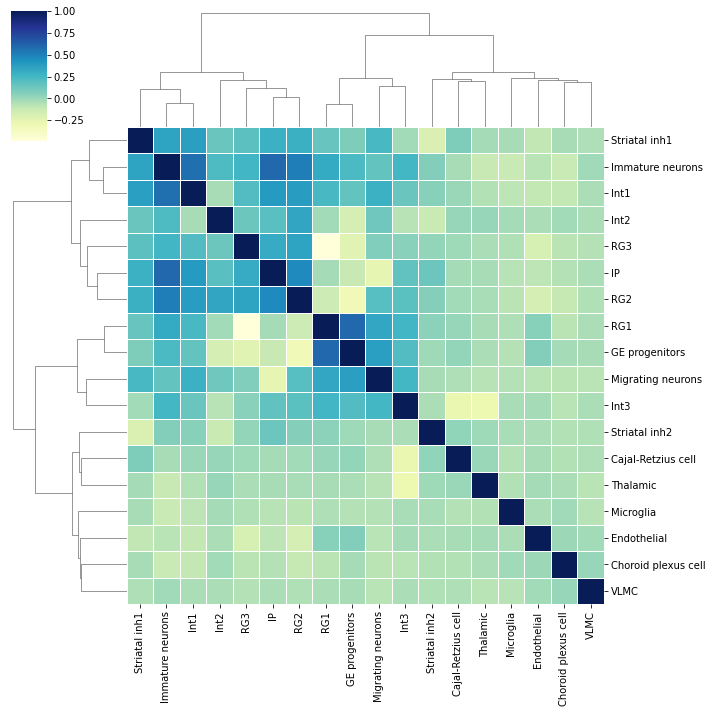

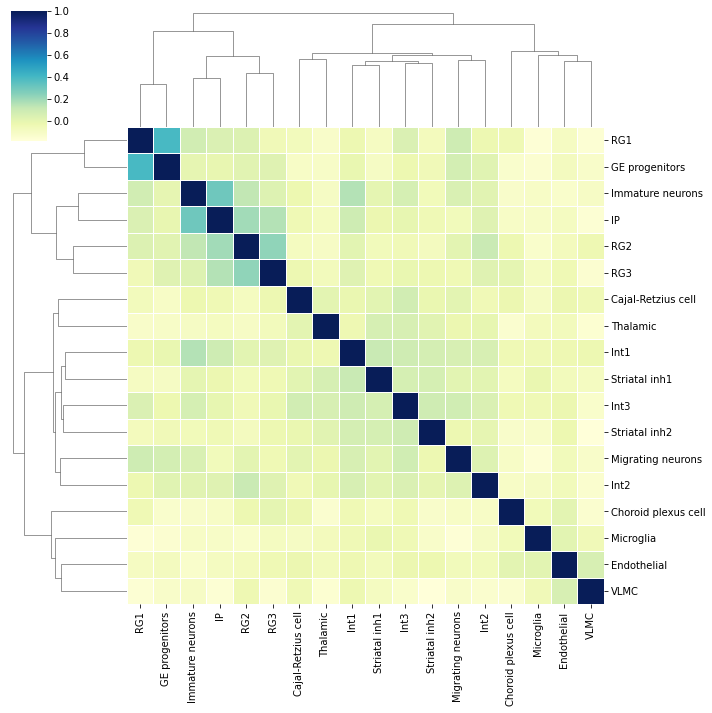

In [7]:
cal_cell_type_corr_among_spots(spatial_adata=spatial_adata_annotated,name="adata_a2p2_tg_pred")

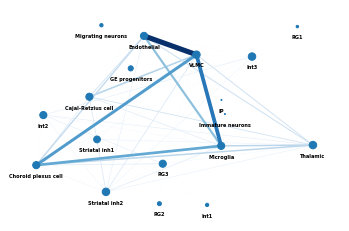

In [18]:
cell_type_network_among_spots(spatial_adata_annotated, name="adata_a2p2_tg_pred", node_size=1)